In [1]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(3,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [91]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

IsADirectoryError: [Errno 21] Is a directory: 'mock_data/.ipynb_checkpoints'

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.53710111e-04 1.81468666e-03 2.67589389e-03
  2.06074587e-03 1.72241446e-03 1.63014225e-03 2.16839677e-03
  3.10649750e-03 2.53748558e-03 6.30526720e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.78392926e-03 3.67550942e-03 3.33717801e-03
  3.50634371e-03 3.92156863e-03 3.92156863e-03 3.46020761e-03
  3.24490581e-03 3.75240292e-03 2.18377547e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00

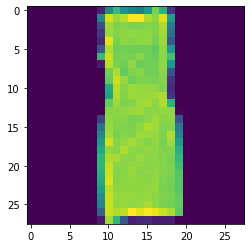

In [2]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1100])
print(images[1100])

In [51]:
from math import acos, floor, sqrt
#submission to part 1, you should make this into a .py file

#n=len(dataset)
mse=0
gatecount=0

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    aim = np.zeros((7,7))
    for x in range(7):
        for y in range(7):
            avg_val = 0
            counter = 0
            for l in range(4):
                for k in range(4):
                    avg_val += image[4*x+l][4*y+k]
                    counter += 1
            aim[x][y] = avg_val / counter

    num_qubits = 4
    q = qiskit.QuantumRegister(num_qubits)
    circuit = qiskit.QuantumCircuit(q)
    for i in range(num_qubits):
        circuit.h(i)
    for x in range(7):
        for y in range(7):
            intensit = aim[x][y]/np.max(aim)
            
            pos_encoding=str(bin(x*len(aim[x])+y))[2:]
            for qubit, val in zip(q[:-1], pos_encoding):
                if val == "1":
                    circuit.x(qubit)
            
            theta = acos(sqrt(intensit))
            circuit.mcry(theta, q[:-1], num_qubits-1)
            # this isnt very efficient and it could be smarter but also it doesnt really impact scoring so why waste more time on this
            for qubit, val in zip(q[:-1], pos_encoding):
                if val == "1":
                    circuit.x(qubit)
    return circuit

def decode(histogram):
    image = np.zeros((7,7))
    for key, value in histogram.items():
        key = bin(key)[2:]
        key = "0"*(4-len(key)) + key
        if key[0] == "0":
            idx = int(key[1:], 2)
            x = floor(idx/7)
            y = idx - x*7
            if x < 7 and y< 7:
                image[x, y] = value
    
    # do some magic extension
    rim = np.zeros((28,28))
    for x in range(7):
        for y in range(7):
            for l in range(4):
                for k in range(4):
                    rim[4*x+l][4*y+k]=image[x,y]

    return rim

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

In [52]:
#how we grade your submission

#n=len(dataset)
mse=0
gatecount=0
f = 0
for im in images[:10]:
    #encode image into circuit
    circuit,image_re=run_part1(im)
    
    #count the number of 2qubit gates used
    gate_count = count_gates(circuit)[2]
    gatecount+=gate_count
    
    #calculate mse
    im_mse = image_mse(im,image_re)
    mse+=im_mse
    f += 1-im_mse
    print(f, gate_count, 0.999**gate_count)
#fidelity of reconstruction
f=f/10
gatecount=gatecount/10

#score for part1 
print(f)
print(f*(0.999**gatecount))

0.9989933900910075 637 0.5287081437599488
1.9983833015922658 637 0.5287081437599488
2.9978079008141334 637 0.5287081437599488
3.997236178514484 637 0.5287081437599488
4.996610105027225 637 0.5287081437599488
5.996160893480878 637 0.5287081437599488
6.995627861883981 637 0.5287081437599488
7.994581258846457 637 0.5287081437599488
8.994154561084422 637 0.5287081437599488
9.993194308251507 637 0.5287081437599488
0.9993194308251507
0.528348321294814


In [ ]:
encode(images[1100]).draw()

In [75]:
qc.draw()

»
q_0: ───────────────────────────────────────────────────────────────────»
                                                                   ┌───┐»
q_1: ──────────────────────────────────────────────────────────────┤ X ├»
                      ┌───┐                  ┌───┐                 └─┬─┘»
q_2: ─────────────────┤ X ├────────■─────────┤ X ├────────■──────────■──»
                      └─┬─┘        │         └─┬─┘        │             »
q_3: ────────■──────────■──────────┼───────────■──────────┼─────────────»
     ┌───────┴───────┐     ┌───────┴────────┐     ┌───────┴───────┐     »
q_4: ┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────»
     └───────────────┘     └────────────────┘     └───────────────┘     »
«                                                                         »
«q_0: ────────────────────────────────────────────────────────────────────»
«                       ┌───┐                 ┌───┐                  ┌───┐»
«q_1: ────────■─────────┤ X ├────────■────────┤ X ├────────■─────────┤ X ├»
«             │         └─┬─┘        │        └─┬─┘        │         └─┬─┘»
«q_2: ────────┼───────────┼──────────┼──────────■──────────┼───────────┼──»
«             │           │          │                     │           │  »
«q_3: ────────┼───────────■──────────┼─────────────────────┼───────────■──»
«     ┌───────┴────────┐     ┌───────┴───────┐     ┌───────┴────────┐     »
«q_4: ┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────»
«     └────────────────┘     └───────────────┘     └────────────────┘     »
«                      ┌───┐                  ┌───┐                 ┌───┐»
«q_0: ─────────────────┤ X ├────────■─────────┤ X ├────────■────────┤ X ├»
«                      └─┬─┘        │         └─┬─┘        │        └─┬─┘»
«q_1: ────────■──────────■──────────┼───────────┼──────────┼──────────┼──»
«             │                     │           │          │          │  »
«q_2: ────────┼─────────────────────┼───────────┼──────────┼──────────■──»
«             │                     │           │          │             »
«q_3: ────────┼─────────────────────┼───────────■──────────┼─────────────»
«     ┌───────┴───────┐     ┌───────┴────────┐     ┌───────┴───────┐     »
«q_4: ┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────»
«     └───────────────┘     └────────────────┘     └───────────────┘     »
«                       ┌───┐                 ┌───┐                  ┌───┐»
«q_0: ────────■─────────┤ X ├────────■────────┤ X ├────────■─────────┤ X ├»
«             │         └─┬─┘        │        └─┬─┘        │         └─┬─┘»
«q_1: ────────┼───────────┼──────────┼──────────■──────────┼───────────┼──»
«             │           │          │                     │           │  »
«q_2: ────────┼───────────┼──────────┼─────────────────────┼───────────┼──»
«             │           │          │                     │           │  »
«q_3: ────────┼───────────■──────────┼─────────────────────┼───────────■──»
«     ┌───────┴────────┐     ┌───────┴───────┐     ┌───────┴────────┐     »
«q_4: ┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────»
«     └────────────────┘     └───────────────┘     └────────────────┘     »
«                      ┌───┐                  ┌───┐                 
«q_0: ────────■────────┤ X ├────────■─────────┤ X ├────────■────────
«             │        └─┬─┘        │         └─┬─┘        │        
«q_1: ────────┼──────────┼──────────┼───────────┼──────────┼────────
«             │          │          │           │          │        
«q_2: ────────┼──────────■──────────┼───────────┼──────────┼────────
«             │                     │           │          │        
«q_3: ────────┼─────────────────────┼───────────■──────────┼────────
«     ┌───────┴───────┐     ┌───────┴────────┐     ┌───────┴───────┐
«q_4: ┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├
«     └───────────────┘     └────────────────┘     └───────────────┘

In [83]:
qc.decompose(reps=2)
qc.draw()

»
q_0: ───────────────────────────────────────────────────────────────────»
                                                                   ┌───┐»
q_1: ──────────────────────────────────────────────────────────────┤ X ├»
                      ┌───┐                  ┌───┐                 └─┬─┘»
q_2: ─────────────────┤ X ├────────■─────────┤ X ├────────■──────────■──»
                      └─┬─┘        │         └─┬─┘        │             »
q_3: ────────■──────────■──────────┼───────────■──────────┼─────────────»
     ┌───────┴───────┐     ┌───────┴────────┐     ┌───────┴───────┐     »
q_4: ┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────»
     └───────────────┘     └────────────────┘     └───────────────┘     »
«                                                                         »
«q_0: ────────────────────────────────────────────────────────────────────»
«                       ┌───┐                 ┌───┐                  ┌───┐»
«q_1: ────────■─────────┤ X ├────────■────────┤ X ├────────■─────────┤ X ├»
«             │         └─┬─┘        │        └─┬─┘        │         └─┬─┘»
«q_2: ────────┼───────────┼──────────┼──────────■──────────┼───────────┼──»
«             │           │          │                     │           │  »
«q_3: ────────┼───────────■──────────┼─────────────────────┼───────────■──»
«     ┌───────┴────────┐     ┌───────┴───────┐     ┌───────┴────────┐     »
«q_4: ┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────»
«     └────────────────┘     └───────────────┘     └────────────────┘     »
«                      ┌───┐                  ┌───┐                 ┌───┐»
«q_0: ─────────────────┤ X ├────────■─────────┤ X ├────────■────────┤ X ├»
«                      └─┬─┘        │         └─┬─┘        │        └─┬─┘»
«q_1: ────────■──────────■──────────┼───────────┼──────────┼──────────┼──»
«             │                     │           │          │          │  »
«q_2: ────────┼─────────────────────┼───────────┼──────────┼──────────■──»
«             │                     │           │          │             »
«q_3: ────────┼─────────────────────┼───────────■──────────┼─────────────»
«     ┌───────┴───────┐     ┌───────┴────────┐     ┌───────┴───────┐     »
«q_4: ┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────»
«     └───────────────┘     └────────────────┘     └───────────────┘     »
«                       ┌───┐                 ┌───┐                  ┌───┐»
«q_0: ────────■─────────┤ X ├────────■────────┤ X ├────────■─────────┤ X ├»
«             │         └─┬─┘        │        └─┬─┘        │         └─┬─┘»
«q_1: ────────┼───────────┼──────────┼──────────■──────────┼───────────┼──»
«             │           │          │                     │           │  »
«q_2: ────────┼───────────┼──────────┼─────────────────────┼───────────┼──»
«             │           │          │                     │           │  »
«q_3: ────────┼───────────■──────────┼─────────────────────┼───────────■──»
«     ┌───────┴────────┐     ┌───────┴───────┐     ┌───────┴────────┐     »
«q_4: ┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────»
«     └────────────────┘     └───────────────┘     └────────────────┘     »
«                      ┌───┐                  ┌───┐                 
«q_0: ────────■────────┤ X ├────────■─────────┤ X ├────────■────────
«             │        └─┬─┘        │         └─┬─┘        │        
«q_1: ────────┼──────────┼──────────┼───────────┼──────────┼────────
«             │          │          │           │          │        
«q_2: ────────┼──────────■──────────┼───────────┼──────────┼────────
«             │                     │           │          │        
«q_3: ────────┼─────────────────────┼───────────■──────────┼────────
«     ┌───────┴───────┐     ┌───────┴────────┐     ┌───────┴───────┐
«q_4: ┤ U(π/32,0,0,0) ├─────┤ U(-π/32,0,0,0) ├─────┤ U(π/32,0,0,0) ├
«     └───────────────┘     └────────────────┘     └───────────────┘

In [77]:
    counter = Counter([len(gate[1]) for gate in circuit.data])


In [84]:
    counter = Counter([len(gate[1]) for gate in qc.data])

counter

Counter({2: 29})

In [39]:
im = images[1]

def smooth(i):
    aim = np.zeros((28,28))
    for x in range(7):
        for y in range(7):
            max_val = -1
            avg_val = 0
            counter = 0
            for l in range(4):
                for k in range(4):
                    avg_val += i[4*x+l][4*y+k]
                    counter += 1
            for l in range(4):
                for k in range(4):
                        aim[4*x+l][4*y+k] = avg_val / counter
    return aim

In [43]:
im = images[1100]
1-image_mse(im, smooth(im))

0.9999994561202254

In [41]:
print(smooth(im)[20][20], smooth(im)[22][22], smooth(im)[23][22], smooth(im)[22][23], smooth(im)[24][24])

0.00035851595540176855 0.00035851595540176855 0.00035851595540176855 0.00035851595540176855 0.0


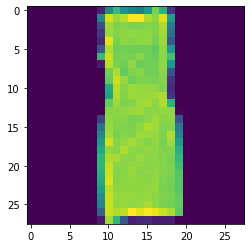

In [44]:
plt.imshow(images[1100])


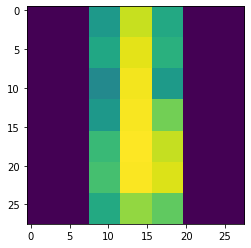

In [45]:
plt.imshow(smooth(im))
